# TODO
* Leitfaden zur Reproduzierung der Slides und Code für
    * Just Code
        Remote: CPU/GPU: Colab
        Remote: CPU only: Blender
        Local: Clone Repo and follow instructions
    * Code with slides:
        Remote: CPU only: Blender
        Local CPU/GPU: Clone repo and follow instructions
* Better CSS for IFIS style slides
    * Have H1 headings on top of screen
    * Have horizontal lines above and below H1 headings
    * Have Content starting at fixed height
    * Add a footer with author name and Institute
    * Swap in our logo
* Add docker container for repo
    * with nvidia docker
* We need a  leaderboard solution for our challenges
    * check out kaggle. We need custom scoring functions and private challenges
* We need a doodle for weekly date finding



# AI Camp 2020 Kickoff

# Agenda
1. What to expect
2. Timeline
3. How we code
    * Jupyter Notebooks
    * Google Colab
4. Lecture 1: Python + Keras
5. Challenge 1: Minimal MNIST

# What to expect

# Timeline
- **KW 16**: (20.04) Kickoff, Intro lecture, Minimal MNIST Competition
    - KW 17: Q&A, optional
- **KW 18**: Reinforcement Learning, Pole Cart Competition
    - KW 19: Q&A, optional
- **KW 20**: Guest lecture: Proc. Kacprowski (Data Science for Biomedicine), **TBD COMP**
    - KW 21: Q&A, optional
- **KW 22**: Comp Recap, NLP Lecture, Sentiment Analysis Competition
    - KW 23: Q&A, optional
- **KW 24: Presentation & selection of our grand competition**
    - KW 25 to 28: Working on our competition
- **KW 29: AI Camp wrap up, presenting the results**

# Regular date
We need day + time for our meetings

# Organizational
 - Lectures & Examples in Python
     - Frameworks: Tensorflow, Pytorch, sklearn, etc.
 - Slides & Code in <a href="https://jupyter.org/">Jupyter Notebooks</a>
 - Everything is located in Niklas' <a href="https://github.com/nikrruun/jupyter-notebooks/tree/aicamp2020">GitHub Repo</a>
     - Branch "aicamp2020"

# Why Jupyter Notebooks?
We want to present math and code for AI models
> We have PowerPoint for this!

But wouldn't it be nice, if we also could
- Actually run the code during presentation
- Interact with it and observe changes
- Easily share it and ship to remote hardware
   


# You're in a simulation
This presentation is just code + markdown: 

In [22]:
import time
for i in range(2):
    print(f"2^{i} =", 2**i)
    time.sleep(1)

2^0 = 1
2^1 = 2


And it's also interactive!

# Features 
* Inline Latex support: $e^yx_k\sum_{i=1}{2^{-i}}$
* Text narratives via markdown (essentially a readme.md)
* Usually, a notebook is a list of sequential code or text cells
    - But, with some effort it automatically translates into a slideshow
* Run a copy on <a href="https://colab.research.google.com">Google Colab</a> in < 1 minute
    

# Google Colab walkthrough
1. Open the link <a href="https://colab.research.google.com">Google Colab</a>
2. Sign up & in, and open a new notebook
3. Go to tab "GitHub" and search for user "nikrruun". Choose as shown below:
<img src="img/slides/colab_github_menu.png">

# Google Colab (2)
4. Click on "<i>kickoff_presentation.ipynb</i>"
    - Generally, Google Colab filters out all available notebooks from a given repository
5. Use the "Content" Navigation (on the left) or scroll down until you see this cell
6. Check if you can run this code cell:

In [20]:
data = [72, 101, 108, 108, 111, 32, 87, 111, 114, 108, 100]
print("".join([chr(x) for x in data]))

Hello World


# Lecture 1: Python & Keras
Python is the current standard for ML and Data Science frameworks:
* Forced indentation
* Interpreted, not compiled
* Extremely slow

# So, why *python*?
It is possible to expose C/C++/CUDA code to python
* Tons of highly optimized frameworks and libraries exist
    * numpy, tensorflow, pytorch, pycuda ...
* Performance still not perfect, but close
* Interpreted code allows for interactive and explorative programming!

# Important libraries
There are a couple of standard tools often used for Data Science in python:
* **numpy**: for fast math and array operations on CPU
* **sklearn**: framework for machine learning pipelines
* **pandas**: data analysis and manipulation framework
* **tensorflow, keras**: Deep learning with gpu support
* **matplotlib**: Data visualization

On your own machine, you will have to manually install them (pip)
* Google Colab comes with all of those pre-installed!

# POV: You are a post office
We are going to classify handwritten digits using Deep Neural Networks.

Steps:
1. Take a look at the dataset
2. Learn something about neural networks
3. Implement it in Keras

# The MNIST dataset
Let us start by importing some libraries that we will use:

In [23]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt


Next, we need to load the dataset. Keras has some built-in functions for that!

In [28]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* `x_train`: 60k 28x28 images used for training
* `y_train`: 60k integer labels
* `x_test`: 10k 28x28 images used for testing
* `y_test`: 10k integer labels

What do these images look like? matplotlib shows us how:

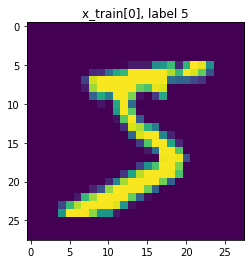

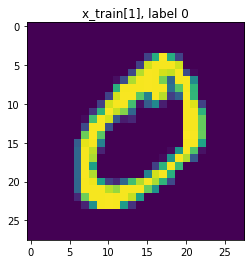

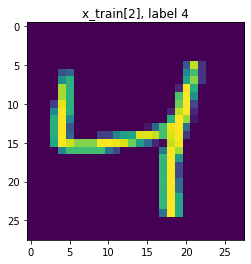

In [30]:
for i in range(3):
    img = x_train[i]
    plt.imshow(img)
    plt.title(f"x_train[{i}], label {y_train[i]}")
    plt.show()

# Step 2: Neural Networks
***
What we want is a function $C$, that assigns each image a number between 0 and 9:

$C: \mathbb{N}_{28\times28}\rightarrow \{0,1,\dots,9\}$

We could also write the images as 1D arrays, row-by-row, so let's also allow

$C: \mathbb{N}_{784\times1}\rightarrow \{0,1,\dots,9\}$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
a = plt.plot(np.random.rand(10), "*")

In [ ]:
import numpy as np
from tensorflow.keras.layers import (
    Dense, Input, Dropout    
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow import keras

import gym

In [ ]:
def episode(env, model, render=False, max_steps=None):
    states = []
    action_probs = []
    est_rewards = []
    rewards = []

    state = env.reset()
    i = 0
    while i < (j := max_steps if max_steps is not None else np.inf):
        if render: 
            env.render()
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        states.append(state)

        a_p, e_w = model(state)
        action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
        state, reward, done, info = env.step(action)

        action_probs.append(a_p[0, action])
        est_rewards.append(e_w[0,0])
        rewards.append(reward)

        i += 1
        if done:
            break
    env.close()
    return states, rewards, action_probs, est_rewards

In [ ]:
epochs = 1000
gamma = 0.9
train_max_steps = 200
validation_every = 5
validation_episodes = 5
validation_max_steps = 200
env = gym.make('CartPole-v0').unwrapped
#env = gym.make('MountainCar-v0').unwrapped

critic_loss_func = keras.losses.Huber()

input_layer = Input(env.observation_space.shape)
l = Dense(128, "relu")(input_layer)
l = Dense(64, "relu")(l)
actor = Dense(env.action_space.n, "softmax", name="actor")(l)
critic = Dense(1, name="critic")(l)
model = Model(input_layer, [actor, critic])

model.summary()
opt = keras.optimizers.Adam(lr=0.01)
reward_history = []

In [ ]:
for epoch in range(epochs):

    with tf.GradientTape() as tape:
        states, rewards, action_probs, est_rewards = episode(env, model, False, train_max_steps)
        reward_history.append(sum(rewards))

        returns = []
        discounted_sum = 0
        for r in rewards[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - returns.mean()) / returns.std()

        critic_labels = tf.convert_to_tensor(returns, "float32")

        # critic_loss = critic_loss_func(est_rewards, critic_labels)
        cl = []
        for f,g in zip(est_rewards, critic_labels):
            cl.append(critic_loss_func(tf.expand_dims(f,0), tf.expand_dims(g,0)))
        critic_loss = sum(cl)

        al = -tf.math.log(action_probs) * (critic_labels - est_rewards)
        actor_loss = sum(al)
        loss = actor_loss + critic_loss

        gradients = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(gradients, model.trainable_weights))

    if epoch % validation_every == 0:
        val_rewards = []
        for val_e in range(validation_episodes):
            states, rewards, action_probs, est_rewards = episode(env, model, False, validation_max_steps)
            val_rewards.append(sum(rewards))
        val_rewards = np.array(val_rewards)
        print(f"Epoch {epoch}/{epochs}",np.mean(reward_history),  val_rewards.min(), val_rewards.max(), val_rewards.mean())
        reward_history.clear()
        #episode(env, model, True, validation_max_steps)
        pass